Palette tabanlı steganografi, dijital resimler içinde bilgi saklama yöntemidir. Palette tabanlı bir resimde kullanılan renkler, sınırlı sayıda renkler içeren bir renk paletinde tanımlanır. Bu teknik, gizli veriyi kodlamak için paletin değiştirilmesini içerir, ancak insan gözüne resmin görünüşünü fark edilir derecede değiştirmez.

**`Bu yöntemde gizli metin palet içine kopyalanır.`**



In [ ]:
from PIL import Image
import os

def encode_message_in_palette(image_path, message):
    """
    Bir resmin renk paletine mesaj kodlar ve yeni resmi kaydeder.
    :param image_path: Palet tabanlı resmin yolu (örneğin, PNG veya GIF).
    :param message: Kodlanacak mesaj.
    :return: Kodlu mesaj içeren Image nesnesinin kaydedildiği yol.
    """
    # Resmi yükle
    img = Image.open(image_path)

    # Resmin 'P' modunda (palet tabanlı) olduğundan emin ol
    if img.mode != 'P':
        raise ValueError("Resim palet modunda (P) olmalı")

    # Mesajı ikili koda çevir
    bin_message = ''.join(format(ord(char), '08b') for char in message)
    bin_message += '0' * 8  # Sonunda 8-bit sıfır (null karakter) ekle

    # Renk paletini al
    palette = img.getpalette()

    # Mesajı paletin en az anlamlı bitlerine kodla
    for i, bit in enumerate(bin_message):
        if i < len(palette):
            # Renk değerinin en az anlamlı bitini ayarla
            if bit == '1':
                palette[i] |= 1
            else:
                palette[i] &= ~1
        else:
            break

    # Değiştirilmiş paleti resme geri koy
    img.putpalette(palette)

    # Yeni resmi kaydet
    # Orijinal resmin adını ve uzantısını al
    file_name, file_extension = os.path.splitext(os.path.basename(image_path))
    new_image_path = f"{file_name}_encoded{file_extension}"

    # Yeni resmi kaydet
    img.save(new_image_path)

    return new_image_path

In [ ]:
def encode_message_in_palette(image_path, message, max_colors=256):
    """
    Bir resmin renk paletine mesaj kodlar. Eğer mesaj çok büyükse hata verir.
    :param image_path: Palet tabanlı resmin yolu (örneğin, PNG veya GIF).
    :param message: Kodlanacak mesaj.
    :param max_colors: Kullanılacak maksimum renk sayısı.
    :return: Kodlu mesaj içeren Image nesnesi.
    """
    # Resmi yükle
    img = Image.open(image_path)

    # Resmin 'P' modunda (palet tabanlı) olduğundan emin ol
    if img.mode != 'P':
        raise ValueError("Resim palet modunda (P) olmalı")

    # Mesajı ikili koda çevir
    bin_message = ''.join(format(ord(char), '08b') for char in message)

    # Eğer mesaj çok büyükse hata ver
    if len(bin_message) > max_colors * 8:
        raise ValueError(f"Mesaj çok büyük! Maksimum {max_colors} renk kullanılabilir (yaklaşık {max_colors // 8} karakter).")

    # Mesajın sonuna 8-bit sıfır (null karakter) ekle
    bin_message += '0' * 8

    # Renk paletini al
    palette = img.getpalette()

    # Mesajı paletin en az anlamlı bitlerine kodla
    for i, bit in enumerate(bin_message):
        if i < len(palette):
            # Renk değerinin en az anlamlı bitini ayarla
            if bit == '1':
                palette[i] |= 1
            else:
                palette[i] &= ~1
        else:
            break

    # Değiştirilmiş paleti resme geri koy
    img.putpalette(palette)

    return img

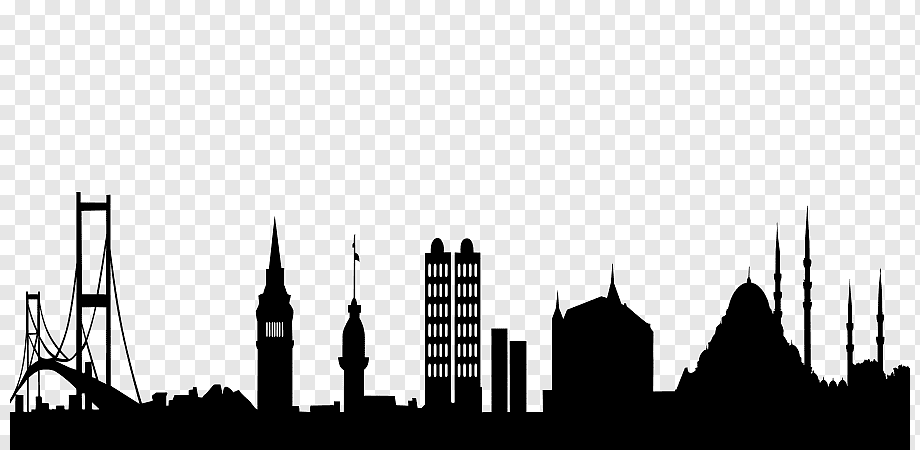

In [ ]:
from IPython.display import Image as ColabImage
ColabImage('original.png')

In [ ]:
image_path = "original.png"
secret_message = "Gizli mesaj!"

stego_image = encode_message_in_palette(image_path, secret_message)

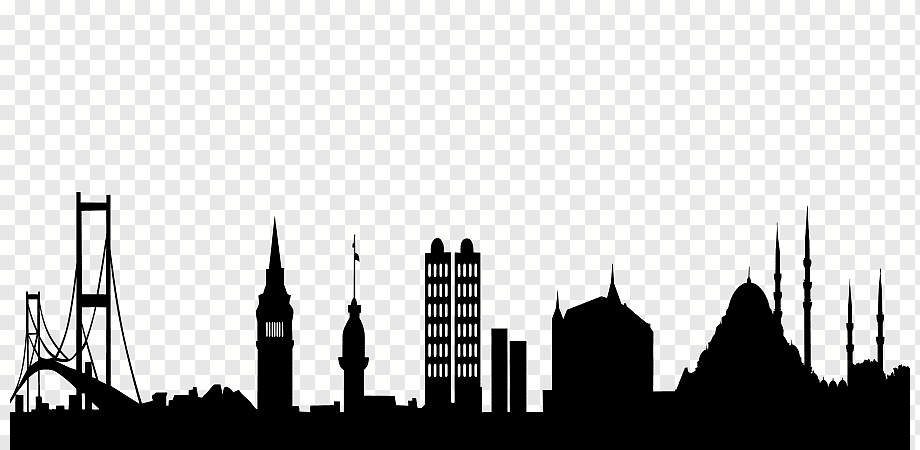

In [ ]:
from IPython.display import Image as ColabImage
ColabImage('original_encoded.png')

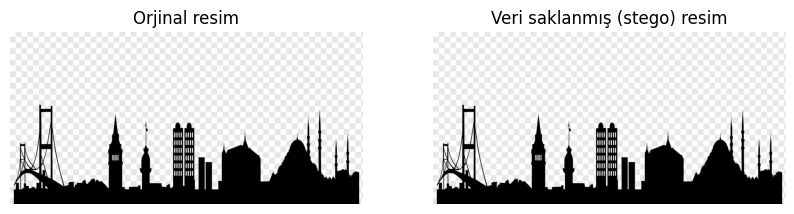

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Resimleri yükleyin
image1 = Image.open('/content/original.png')
image2 = Image.open('/content/original_encoded.png')

# Figür ve eksenleri oluşturun
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# İlk resmi göster
axes[0].imshow(image1)
axes[0].axis('off')  # Eksenleri gizle
axes[0].set_title('Orjinal resim')

# İkinci resmi göster
axes[1].imshow(image2)
axes[1].axis('off')  # Eksenleri gizle
axes[1].set_title('Veri saklanmış (stego) resim')

# Gösterimi yap
plt.show()

In [ ]:
! md5sum *.png

58b1bfbd79c598c9a847f32221b23034  original_encoded.png
6345b58b0d42375bec678e3572dfaed9  original.png


In [ ]:
! diff original.png original_encoded.png

Binary files original.png and original_encoded.png differ


In [ ]:
! ls -al *.png

-rw-r--r-- 1 root root 9855 Jan 15 00:58 original_encoded.png
-rw-r--r-- 1 root root 8601 Jan 15 00:54 original.png


In [ ]:
def decode_message_from_palette(image_path, max_colors=256):
    """
    Bir resmin renk paletinden mesajı çözer.
    :param image_path: Mesaj kodlu palet tabanlı resmin yolu (örneğin, PNG veya GIF).
    :param max_colors: Kullanılacak maksimum renk sayısı (varsayılan 256).
    :return: Çözülen mesaj.
    """
    # Resmi yükle
    img = Image.open(image_path)

    # Resmin 'P' modunda (palet tabanlı) olduğundan emin ol
    if img.mode != 'P':
        raise ValueError("Resim palet modunda (P) olmalı")

    # Renk paletini al
    palette = img.getpalette()

    # Mesajı paletin en az anlamlı bitlerinden çöz
    bin_message = ''
    for color_value in palette[:max_colors]:
        bin_message += str(color_value & 1)

    # İkiliden metne çevir
    message = ''
    for i in range(0, len(bin_message), 8):
        byte = bin_message[i:i+8]
        if byte == '00000000':  # Null karakter (mesajın sonu)
            break
        message += chr(int(byte, 2))

    return message

In [40]:
secret_message = decode_message_from_palette('original_encoded.png')
print(secret_message)

Giz


## **PNG Check**

In [41]:
! sudo apt install pngcheck

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  pngcheck
0 upgraded, 1 newly installed, 0 to remove and 24 not upgraded.
Need to get 66.6 kB of archives.
After this operation, 204 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 pngcheck amd64 3.0.2-2 [66.6 kB]
Fetched 66.6 kB in 1s (105 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package pngcheck.
(Reading database ... 121654 files and directories curre

In [44]:
! pngcheck -v original.png

File: original.png (8601 bytes)
  chunk IHDR at offset 0x0000c, length 13
    920 x 450 image, 4-bit palette, non-interlaced
  chunk PLTE at offset 0x00025, length 30: 10 palette entries
  chunk IDAT at offset 0x0004f, length 8192
    zlib: deflated, 32K window, maximum compression
  chunk IDAT at offset 0x0205b, length 298
  chunk IEND at offset 0x02191, length 0
No errors detected in original.png (5 chunks, 95.8% compression).


In [45]:
! pngcheck -v original_encoded.png

File: original_encoded.png (9855 bytes)
  chunk IHDR at offset 0x0000c, length 13
    920 x 450 image, 4-bit palette, non-interlaced
  chunk PLTE at offset 0x00025, length 30: 10 palette entries
  chunk IDAT at offset 0x0004f, length 9756
    zlib: deflated, 32K window, default compression
  chunk IEND at offset 0x02677, length 0
No errors detected in original_encoded.png (4 chunks, 95.2% compression).


In [42]:
! pngcheck -v image.png

File: image.png (40711 bytes)
  chunk IHDR at offset 0x0000c, length 13
    2560 x 1440 image, 32-bit RGB+alpha, non-interlaced
  chunk bKGD at offset 0x00025, length 6
    red = 0x00ee, green = 0x00ee, blue = 0x00ee
  chunk pHYs at offset 0x00037, length 9: 2835x2835 pixels/meter (72 dpi)
  chunk IDAT at offset 0x0004c, length 8192
    zlib: deflated, 32K window, maximum compression
  chunk IDAT at offset 0x02058, length 8192
  chunk IDAT at offset 0x04064, length 8192
  chunk IDAT at offset 0x06070, length 8192
  chunk IDAT at offset 0x0807c, length 7799
  chunk IEND at offset 0x09eff, length 0
No errors detected in image.png (9 chunks, 99.7% compression).
